In [1]:
import sys
%load_ext autoreload
%autoreload 2
sys.path.insert(0, '../..')

In [2]:
import os
import pandas as pd
from src.utils.preprocess import preprocess_video, split_video, split_audio
import librosa
from datetime import datetime
from src.utils.model import get_audio_model, get_visual_model, find_ckpt
from src.utils.transforms import get_video_transforms
from src.utils.engine import yaml_search, get_recording_filename, read_frames, get_recording_paths, predict, \
    predict_with_files

In [3]:
from moviepy.video.io.VideoFileClip import VideoFileClip


def cvt_25fps(input_file, output_file):
    # Load the video clip
    clip = VideoFileClip(input_file)
    # Set the target frame rate to 25 FPS
    target_fps = 25
    # Convert the clip to 25 FPS
    clip_25fps = clip.set_fps(target_fps)
    # Write the converted clip to a new file
    clip_25fps.write_videofile(output_file, codec="libx264")
    # Close the clip
    clip.close()


def extract_audio(input_file, output_file):
    # Load the video clip
    clip = VideoFileClip(input_file)
    # Extract the audio from the video
    audio = clip.audio
    # Save the audio as a WAV file
    audio.write_audiofile(output_file, codec="pcm_s16le")
    # Close the clip
    clip.close()

In [4]:
from pathlib import Path

person = "Najwa"
base_dir = f"../resources/data/YouTube/{person}"
cut_dir = f"{base_dir}/cut"
pred_dir = f"{base_dir}/prediction"
processed_dir = f"{base_dir}/processed"
Path(processed_dir).mkdir(parents=True, exist_ok=True)
Path(pred_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
for file in os.listdir(cut_dir):
    basename = file.split(".")[0]
    cvt_25fps(
        input_file=f"{cut_dir}/{basename}.mp4",
        output_file=f"{processed_dir}/{basename}.mp4"
    )
    extract_audio(
        input_file=f"{cut_dir}/{basename}.mp4",
        output_file=f"{processed_dir}/{basename}.wav"
    )

In [9]:
videos = []
audios = []
unique = []
for file in os.listdir(processed_dir):
    # Load Video & Audio
    basename = file.split(".")[0]
    if basename in unique: continue
    ori_video, (w, h) = read_frames(f"{processed_dir}/{basename}.mp4")
    ori_audio, _ = librosa.load(f"{processed_dir}/{basename}.wav", sr=16000)
    videos.append(ori_video)
    audios.append(ori_audio)
    unique.append(basename)

1
10
11
12
2
4
5
6
7
9


In [ ]:
len(videos)

In [11]:
def generate_filenames():
    # Filenames for Target
    dt = datetime.now()
    time = int(dt.strftime("%Y%m%d%H%M%S"))
    filepath = f"{cwd}/results"
    filename = f"{time}"
    filename_prediction = f"{filename}_Prediction.MP4"
    filepath_prediction = f"{filepath}/{filename_prediction}"
    filename_latent = f"{filename}_Latent.MP4"
    filepath_latent = f"{filepath}/{filename_latent}"
    filename_ori = f"{filename}_Original.MP4"
    filepath_ori = f"{filepath}/{filename_ori}"
    return filepath_prediction, filepath_latent, filepath_ori

In [12]:
from torchmetrics.functional.audio.stoi import short_time_objective_intelligibility
from torchmetrics.functional.audio.pesq import perceptual_evaluation_speech_quality
from tqdm import tqdm

In [13]:
def print_metric(pesq, stoi, estoi):
    print("------------------")
    print("PESQ:", pesq)
    print("STOI:", stoi)
    print("ESTOI:", estoi)
    print("------------------")

In [14]:
import torch
import numpy as np
import soundfile as sf

def sew_audios(wavs):
    audio_data = []

    for wav in wavs:
        audio_data.append(wav)

    # Concatenate the audio data
    concatenated_data = np.concatenate(audio_data)
    return concatenated_data

def cut_ori_audio(ori_audio, total_frames, sr=16000, fps=25):
    frame = sr//fps
    print(int(total_frames*frame))
    return ori_audio[:int(total_frames*frame)]

def prep_audio(modified_audio, target_length):
    # Adjust the length of the resampled modified audio to match the target length
    if len(modified_audio) > target_length:
        modified_audio = modified_audio[:target_length]
    elif len(modified_audio) < target_length:
        modified_audio = librosa.util.fix_length(modified_audio, size=target_length)

    return modified_audio

In [15]:
def load_model(model, cwd, _type, frames, run_name):
    default_ckpt_path = f"{cwd}/models/ilmsg-{_type}/f{frames}"
    ckpt_filename = find_ckpt(f"{default_ckpt_path}/{run_name}/")
    ckpt_path = f"{default_ckpt_path}/{run_name}/{ckpt_filename}"
    model = model.load_from_checkpoint(ckpt_path).cuda()
    return model


def reload_model(cwd, model_conf, data, experiment, learning_rate):
    vmodel = get_visual_model(model_conf["version"], learning_rate, model_conf["name"], experiment)
    amodel = get_audio_model(data["audio_version"], learning_rate, data["audio_run"])
    # Load Audio CKPT
    amodel = load_model(amodel, cwd, "audio", data["frames"], data["audio_run"])
    # Load Video CKPT
    vmodel = load_model(vmodel, cwd, "video", data["frames"], model_conf["name"])
    amodel.eval()
    vmodel.eval()
    return amodel, vmodel

In [16]:
cwd = f"{os.getcwd()}/../../src/resources"
# Pria: 66,68,88,87,90
# Wanita: 106, 107, 109, 110, 108
run_model = 104
experiment = yaml_search(f"{cwd}/experiments/video", run_model)

hparams = experiment["hyperparameters"]
config = experiment["config"]
data = experiment["data"]

seed, batch_size, learning_rate = hparams["seed"], hparams["batch_size"], float(hparams["learning_rate"])
model_conf = experiment["model"]
config = experiment["config"]
data = experiment["data"]
transforms = get_video_transforms(data["transform"], data["color"])
arr_size = [150, 150]

audio_model, visual_model = reload_model(cwd, model_conf, data, experiment, learning_rate)

odict_keys(['pretrained_model.0.0.weight', 'pretrained_model.0.1.weight', 'pretrained_model.0.1.bias', 'pretrained_model.0.1.running_mean', 'pretrained_model.0.1.running_var', 'pretrained_model.0.1.num_batches_tracked', 'pretrained_model.1.0.block.0.0.weight', 'pretrained_model.1.0.block.0.1.weight', 'pretrained_model.1.0.block.0.1.bias', 'pretrained_model.1.0.block.0.1.running_mean', 'pretrained_model.1.0.block.0.1.running_var', 'pretrained_model.1.0.block.0.1.num_batches_tracked', 'pretrained_model.1.1.block.0.0.weight', 'pretrained_model.1.1.block.0.1.weight', 'pretrained_model.1.1.block.0.1.bias', 'pretrained_model.1.1.block.0.1.running_mean', 'pretrained_model.1.1.block.0.1.running_var', 'pretrained_model.1.1.block.0.1.num_batches_tracked', 'pretrained_model.2.0.block.0.0.weight', 'pretrained_model.2.0.block.0.1.weight', 'pretrained_model.2.0.block.0.1.bias', 'pretrained_model.2.0.block.0.1.running_mean', 'pretrained_model.2.0.block.0.1.running_var', 'pretrained_model.2.0.block.0.

In [17]:
scores = {}
scores["PESQ"] = []
scores["STOI"] = []
scores["ESTOI"] = []
for i in tqdm(range(len(videos))):
# for i in tqdm(range(1, 2)):
    filepath_prediction, filepath_latent, filepath_ori = generate_filenames()
    ori_video = videos[i]
    ori_audio = audios[i]
    preprocessed_frames = preprocess_video(
        rid=None,
        transforms=transforms,
        frames=ori_video,
        vid_size=arr_size,
        local=False,
        to_gray=True
    )
    # Split Video
    video_batch = split_video(
        frames=preprocessed_frames,
        split_frames=data["frames"],
        stride=data["frames"],
        total_frames=len(preprocessed_frames)
    )
    video_batch = video_batch.cuda()

    pred_audios = []
    pred_latents = []
    pred_mels = []

    for j in range(len(video_batch)):
        video = video_batch[j].unsqueeze(0).cuda()

        (ori_mels, ori_latent, ori_audio), (target_mels, target_latent, target_wav) = predict(
            visual_model=visual_model,
            filepaths=(filepath_prediction, filepath_latent, filepath_ori),
            ori_video=ori_video,
            video_batch=video,
            audio_model=audio_model,
            ori_audio=ori_audio,
            label_batch=None,
            generate_video=False
        )
        pred_audios.append(target_wav)
        pred_latents.append(target_latent)
        pred_mels.append(target_mels)

        # audio_model, visual_model = reload_model(cwd, model_conf, data, experiment, learning_rate)
        del video
        torch.cuda.empty_cache()
    target_wav = sew_audios(pred_audios)
    target_wav = prep_audio(target_wav, len(ori_audio))
    target_wav = torch.from_numpy(target_wav)
    ori_audio = torch.from_numpy(ori_audio)
    sf.write(f"{pred_dir}/{i}_pred.wav", target_wav, samplerate=16000)
    sf.write(f"{pred_dir}/{i}_ori.wav", ori_audio, samplerate=16000)
    pesq = perceptual_evaluation_speech_quality(target_wav, ori_audio, 16000, "wb")
    stoi = short_time_objective_intelligibility(target_wav, ori_audio, 16000).float()
    estoi = short_time_objective_intelligibility(target_wav, ori_audio, 16000, extended=True).float()
    scores["PESQ"].append(pesq)
    scores["STOI"].append(stoi)
    scores["ESTOI"].append(estoi)
    print_metric(pesq, stoi, estoi)



  0%|          | 0/10 [00:00<?, ?it/s]

<_dlib_pybind11.fhog_object_detector object at 0x7f4ff614f970> <_dlib_pybind11.shape_predictor object at 0x7f4ff615f0f0>
Calculate Centroid




  0%|          | 0/108 [00:00<?, ?it/s]

  1%|          | 1/108 [00:00<00:20,  5.16it/s]

  2%|▏         | 2/108 [00:00<00:19,  5.56it/s]

  3%|▎         | 3/108 [00:00<00:18,  5.67it/s]

  4%|▎         | 4/108 [00:00<00:18,  5.74it/s]

  5%|▍         | 5/108 [00:00<00:17,  5.76it/s]

  6%|▌         | 6/108 [00:01<00:17,  5.76it/s]

  6%|▋         | 7/108 [00:01<00:17,  5.78it/s]

  7%|▋         | 8/108 [00:01<00:17,  5.81it/s]

  8%|▊         | 9/108 [00:01<00:17,  5.80it/s]

  9%|▉         | 10/108 [00:01<00:16,  5.80it/s]

 10%|█         | 11/108 [00:01<00:16,  5.79it/s]

 11%|█         | 12/108 [00:02<00:16,  5.79it/s]

 12%|█▏        | 13/108 [00:02<00:16,  5.78it/s]

 13%|█▎        | 14/108 [00:02<00:16,  5.78it/s]

 14%|█▍        | 15/108 [00:02<00:16,  5.79it/s]

 15%|█▍        | 16/108 [00:02<00:15,  5.79it/s]

 16%|█▌        | 17/108 [00:02<00:15,  5.79it/s]

 17%|█▋        | 18/108 [00:03<00:15,  5.80it/s]

 18%|█▊        | 19/108 [00:03<00:15,  5.81it/s]

 19%|█▊        |

[701.34259259 390.14814815]
{'cx': 701.3425925925926, 'cy': 390.14814814814815}



 10%|█         | 1/10 [00:22<03:24, 22.76s/it]

------------------
PESQ: tensor(1.0592)
STOI: tensor(0.1291)
ESTOI: tensor(-0.0627)
------------------
<_dlib_pybind11.fhog_object_detector object at 0x7f511c120bf0> <_dlib_pybind11.shape_predictor object at 0x7f4ffa186fb0>
Calculate Centroid




  0%|          | 0/84 [00:00<?, ?it/s]

  1%|          | 1/84 [00:00<00:16,  5.04it/s]

  2%|▏         | 2/84 [00:00<00:15,  5.39it/s]

  4%|▎         | 3/84 [00:00<00:14,  5.55it/s]

  5%|▍         | 4/84 [00:00<00:14,  5.61it/s]

  6%|▌         | 5/84 [00:00<00:13,  5.69it/s]

  7%|▋         | 6/84 [00:01<00:13,  5.74it/s]

  8%|▊         | 7/84 [00:01<00:13,  5.76it/s]

 10%|▉         | 8/84 [00:01<00:13,  5.79it/s]

 11%|█         | 9/84 [00:01<00:12,  5.81it/s]

 12%|█▏        | 10/84 [00:01<00:12,  5.83it/s]

 13%|█▎        | 11/84 [00:01<00:12,  5.86it/s]

 14%|█▍        | 12/84 [00:02<00:12,  5.88it/s]

 15%|█▌        | 13/84 [00:02<00:12,  5.89it/s]

 17%|█▋        | 14/84 [00:02<00:11,  5.90it/s]

 18%|█▊        | 15/84 [00:02<00:11,  5.89it/s]

 19%|█▉        | 16/84 [00:02<00:11,  5.89it/s]

 20%|██        | 17/84 [00:02<00:11,  5.90it/s]

 21%|██▏       | 18/84 [00:03<00:11,  5.89it/s]

 23%|██▎       | 19/84 [00:03<00:11,  5.89it/s]

 24%|██▍       | 20/84 [00:03<00:10,

[701.83333333 386.17857143]
{'cx': 701.8333333333334, 'cy': 386.17857142857144}



 20%|██        | 2/10 [00:39<02:35, 19.44s/it]

------------------
PESQ: tensor(1.0901)
STOI: tensor(0.1748)
ESTOI: tensor(-0.0021)
------------------
<_dlib_pybind11.fhog_object_detector object at 0x7f4ffa15e730> <_dlib_pybind11.shape_predictor object at 0x7f4ffa15ea30>
Calculate Centroid




  0%|          | 0/95 [00:00<?, ?it/s]

  1%|          | 1/95 [00:00<00:16,  5.85it/s]

  2%|▏         | 2/95 [00:00<00:16,  5.78it/s]

  3%|▎         | 3/95 [00:00<00:15,  5.77it/s]

  4%|▍         | 4/95 [00:00<00:15,  5.75it/s]

  5%|▌         | 5/95 [00:00<00:15,  5.78it/s]

  6%|▋         | 6/95 [00:01<00:15,  5.80it/s]

  7%|▋         | 7/95 [00:01<00:15,  5.79it/s]

  8%|▊         | 8/95 [00:01<00:15,  5.80it/s]

  9%|▉         | 9/95 [00:01<00:14,  5.78it/s]

 11%|█         | 10/95 [00:01<00:14,  5.75it/s]

 12%|█▏        | 11/95 [00:01<00:14,  5.78it/s]

 13%|█▎        | 12/95 [00:02<00:14,  5.80it/s]

 14%|█▎        | 13/95 [00:02<00:14,  5.81it/s]

 15%|█▍        | 14/95 [00:02<00:13,  5.82it/s]

 16%|█▌        | 15/95 [00:02<00:13,  5.82it/s]

 17%|█▋        | 16/95 [00:02<00:13,  5.82it/s]

 18%|█▊        | 17/95 [00:02<00:13,  5.81it/s]

 19%|█▉        | 18/95 [00:03<00:13,  5.80it/s]

 20%|██        | 19/95 [00:03<00:13,  5.77it/s]

 21%|██        | 20/95 [00:03<00:12,

[642.92631579 330.96842105]
{'cx': 642.9263157894737, 'cy': 330.9684210526316}



 30%|███       | 3/10 [00:58<02:15, 19.29s/it]

------------------
PESQ: tensor(1.0300)
STOI: tensor(0.1780)
ESTOI: tensor(0.0284)
------------------
<_dlib_pybind11.fhog_object_detector object at 0x7f4ffa73aa70> <_dlib_pybind11.shape_predictor object at 0x7f4ff9d5cd30>
Calculate Centroid




  0%|          | 0/65 [00:00<?, ?it/s]

  2%|▏         | 1/65 [00:00<00:11,  5.79it/s]

  3%|▎         | 2/65 [00:00<00:10,  5.80it/s]

  5%|▍         | 3/65 [00:00<00:10,  5.79it/s]

  6%|▌         | 4/65 [00:00<00:10,  5.78it/s]

  8%|▊         | 5/65 [00:00<00:10,  5.79it/s]

  9%|▉         | 6/65 [00:01<00:10,  5.77it/s]

 11%|█         | 7/65 [00:01<00:10,  5.77it/s]

 12%|█▏        | 8/65 [00:01<00:09,  5.77it/s]

 14%|█▍        | 9/65 [00:01<00:09,  5.78it/s]

 15%|█▌        | 10/65 [00:01<00:09,  5.79it/s]

 17%|█▋        | 11/65 [00:01<00:09,  5.79it/s]

 18%|█▊        | 12/65 [00:02<00:09,  5.78it/s]

 20%|██        | 13/65 [00:02<00:08,  5.78it/s]

 22%|██▏       | 14/65 [00:02<00:08,  5.79it/s]

 23%|██▎       | 15/65 [00:02<00:08,  5.79it/s]

 25%|██▍       | 16/65 [00:02<00:08,  5.79it/s]

 26%|██▌       | 17/65 [00:02<00:08,  5.80it/s]

 28%|██▊       | 18/65 [00:03<00:08,  5.79it/s]

 29%|██▉       | 19/65 [00:03<00:07,  5.78it/s]

 31%|███       | 20/65 [00:03<00:07,

[638.75384615 266.46153846]
{'cx': 638.7538461538461, 'cy': 266.46153846153845}



 40%|████      | 4/10 [01:12<01:41, 16.97s/it]

------------------
PESQ: tensor(1.0366)
STOI: tensor(0.1145)
ESTOI: tensor(-0.0105)
------------------
<_dlib_pybind11.fhog_object_detector object at 0x7f4ff9dc9e70> <_dlib_pybind11.shape_predictor object at 0x7f4ff9ce4b30>
Calculate Centroid




  0%|          | 0/128 [00:00<?, ?it/s]

  1%|          | 1/128 [00:00<00:21,  5.84it/s]

  2%|▏         | 2/128 [00:00<00:21,  5.82it/s]

  2%|▏         | 3/128 [00:00<00:21,  5.83it/s]

  3%|▎         | 4/128 [00:00<00:21,  5.83it/s]

  4%|▍         | 5/128 [00:00<00:21,  5.82it/s]

  5%|▍         | 6/128 [00:01<00:20,  5.83it/s]

  5%|▌         | 7/128 [00:01<00:20,  5.81it/s]

  6%|▋         | 8/128 [00:01<00:20,  5.82it/s]

  7%|▋         | 9/128 [00:01<00:20,  5.82it/s]

  8%|▊         | 10/128 [00:01<00:20,  5.82it/s]

  9%|▊         | 11/128 [00:01<00:20,  5.82it/s]

  9%|▉         | 12/128 [00:02<00:19,  5.84it/s]

 10%|█         | 13/128 [00:02<00:19,  5.86it/s]

 11%|█         | 14/128 [00:02<00:19,  5.83it/s]

 12%|█▏        | 15/128 [00:02<00:19,  5.83it/s]

 12%|█▎        | 16/128 [00:02<00:19,  5.81it/s]

 13%|█▎        | 17/128 [00:02<00:19,  5.82it/s]

 14%|█▍        | 18/128 [00:03<00:18,  5.84it/s]

 15%|█▍        | 19/128 [00:03<00:18,  5.86it/s]

 16%|█▌        |

[588.828125 261.953125]
{'cx': 588.828125, 'cy': 261.953125}



 50%|█████     | 5/10 [01:37<01:40, 20.08s/it]

------------------
PESQ: tensor(1.0743)
STOI: tensor(0.1301)
ESTOI: tensor(0.0050)
------------------
<_dlib_pybind11.fhog_object_detector object at 0x7f4ffa8e46b0> <_dlib_pybind11.shape_predictor object at 0x7f4ffa8e4730>
Calculate Centroid




  0%|          | 0/169 [00:00<?, ?it/s]

  1%|          | 1/169 [00:00<00:30,  5.57it/s]

  1%|          | 2/169 [00:00<00:29,  5.66it/s]

  2%|▏         | 3/169 [00:00<00:29,  5.62it/s]

  2%|▏         | 4/169 [00:00<00:29,  5.69it/s]

  3%|▎         | 5/169 [00:00<00:28,  5.71it/s]

  4%|▎         | 6/169 [00:01<00:28,  5.74it/s]

  4%|▍         | 7/169 [00:01<00:28,  5.76it/s]

  5%|▍         | 8/169 [00:01<00:27,  5.75it/s]

  5%|▌         | 9/169 [00:01<00:27,  5.75it/s]

  6%|▌         | 10/169 [00:01<00:28,  5.65it/s]

  7%|▋         | 11/169 [00:01<00:28,  5.60it/s]

  7%|▋         | 12/169 [00:02<00:27,  5.65it/s]

  8%|▊         | 13/169 [00:02<00:27,  5.69it/s]

  8%|▊         | 14/169 [00:02<00:27,  5.73it/s]

  9%|▉         | 15/169 [00:02<00:26,  5.76it/s]

  9%|▉         | 16/169 [00:02<00:26,  5.78it/s]

 10%|█         | 17/169 [00:02<00:26,  5.81it/s]

 11%|█         | 18/169 [00:03<00:25,  5.82it/s]

 11%|█         | 19/169 [00:03<00:25,  5.82it/s]

 12%|█▏        |

[591.78698225 267.8816568 ]
{'cx': 591.7869822485208, 'cy': 267.8816568047337}



 60%|██████    | 6/10 [02:11<01:39, 24.81s/it]

------------------
PESQ: tensor(1.0878)
STOI: tensor(0.1604)
ESTOI: tensor(0.0083)
------------------
<_dlib_pybind11.fhog_object_detector object at 0x7f4ffa9ce1f0> <_dlib_pybind11.shape_predictor object at 0x7f4ffa9ce2f0>
Calculate Centroid




  0%|          | 0/140 [00:00<?, ?it/s]

  1%|          | 1/140 [00:00<00:23,  5.92it/s]

  1%|▏         | 2/140 [00:00<00:23,  5.91it/s]

  2%|▏         | 3/140 [00:00<00:23,  5.90it/s]

  3%|▎         | 4/140 [00:00<00:23,  5.91it/s]

  4%|▎         | 5/140 [00:00<00:22,  5.92it/s]

  4%|▍         | 6/140 [00:01<00:22,  5.92it/s]

  5%|▌         | 7/140 [00:01<00:22,  5.92it/s]

  6%|▌         | 8/140 [00:01<00:22,  5.92it/s]

  6%|▋         | 9/140 [00:01<00:22,  5.92it/s]

  7%|▋         | 10/140 [00:01<00:21,  5.92it/s]

  8%|▊         | 11/140 [00:01<00:21,  5.90it/s]

  9%|▊         | 12/140 [00:02<00:21,  5.90it/s]

  9%|▉         | 13/140 [00:02<00:21,  5.85it/s]

 10%|█         | 14/140 [00:02<00:21,  5.81it/s]

 11%|█         | 15/140 [00:02<00:21,  5.85it/s]

 11%|█▏        | 16/140 [00:02<00:21,  5.81it/s]

 12%|█▏        | 17/140 [00:02<00:20,  5.86it/s]

 13%|█▎        | 18/140 [00:03<00:20,  5.89it/s]

 14%|█▎        | 19/140 [00:03<00:20,  5.90it/s]

 14%|█▍        |

[593.99285714 251.05      ]
{'cx': 593.9928571428571, 'cy': 251.05}



 70%|███████   | 7/10 [02:40<01:17, 25.90s/it]

------------------
PESQ: tensor(1.0641)
STOI: tensor(0.1534)
ESTOI: tensor(-0.0149)
------------------
<_dlib_pybind11.fhog_object_detector object at 0x7f4ffa15e770> <_dlib_pybind11.shape_predictor object at 0x7f4ffa9f29b0>
Calculate Centroid




  0%|          | 0/87 [00:00<?, ?it/s]

  1%|          | 1/87 [00:00<00:14,  5.82it/s]

  2%|▏         | 2/87 [00:00<00:14,  5.81it/s]

  3%|▎         | 3/87 [00:00<00:14,  5.80it/s]

  5%|▍         | 4/87 [00:00<00:14,  5.78it/s]

  6%|▌         | 5/87 [00:00<00:14,  5.74it/s]

  7%|▋         | 6/87 [00:01<00:14,  5.74it/s]

  8%|▊         | 7/87 [00:01<00:13,  5.73it/s]

  9%|▉         | 8/87 [00:01<00:13,  5.73it/s]

 10%|█         | 9/87 [00:01<00:13,  5.73it/s]

 11%|█▏        | 10/87 [00:01<00:13,  5.69it/s]

 13%|█▎        | 11/87 [00:01<00:13,  5.70it/s]

 14%|█▍        | 12/87 [00:02<00:13,  5.71it/s]

 15%|█▍        | 13/87 [00:02<00:12,  5.72it/s]

 16%|█▌        | 14/87 [00:02<00:12,  5.70it/s]

 17%|█▋        | 15/87 [00:02<00:12,  5.74it/s]

 18%|█▊        | 16/87 [00:02<00:12,  5.75it/s]

 20%|█▉        | 17/87 [00:02<00:12,  5.71it/s]

 21%|██        | 18/87 [00:03<00:12,  5.72it/s]

 22%|██▏       | 19/87 [00:03<00:11,  5.72it/s]

 23%|██▎       | 20/87 [00:03<00:11,

[678.8045977  408.75862069]
{'cx': 678.8045977011494, 'cy': 408.7586206896552}



 80%|████████  | 8/10 [02:57<00:46, 23.34s/it]

------------------
PESQ: tensor(1.1616)
STOI: tensor(0.1721)
ESTOI: tensor(0.0417)
------------------
<_dlib_pybind11.fhog_object_detector object at 0x7f4ffafef130> <_dlib_pybind11.shape_predictor object at 0x7f4ffa9c24f0>
Calculate Centroid




  0%|          | 0/191 [00:00<?, ?it/s]

  1%|          | 1/191 [00:00<00:32,  5.79it/s]

  1%|          | 2/191 [00:00<00:32,  5.78it/s]

  2%|▏         | 3/191 [00:00<00:32,  5.81it/s]

  2%|▏         | 4/191 [00:00<00:32,  5.80it/s]

  3%|▎         | 5/191 [00:00<00:32,  5.80it/s]

  3%|▎         | 6/191 [00:01<00:31,  5.82it/s]

  4%|▎         | 7/191 [00:01<00:31,  5.81it/s]

  4%|▍         | 8/191 [00:01<00:31,  5.82it/s]

  5%|▍         | 9/191 [00:01<00:31,  5.81it/s]

  5%|▌         | 10/191 [00:01<00:31,  5.81it/s]

  6%|▌         | 11/191 [00:01<00:30,  5.82it/s]

  6%|▋         | 12/191 [00:02<00:30,  5.81it/s]

  7%|▋         | 13/191 [00:02<00:30,  5.81it/s]

  7%|▋         | 14/191 [00:02<00:30,  5.82it/s]

  8%|▊         | 15/191 [00:02<00:30,  5.81it/s]

  8%|▊         | 16/191 [00:02<00:30,  5.81it/s]

  9%|▉         | 17/191 [00:02<00:29,  5.81it/s]

  9%|▉         | 18/191 [00:03<00:29,  5.81it/s]

 10%|▉         | 19/191 [00:03<00:29,  5.82it/s]

 10%|█         |

[597.62827225 259.10994764]
{'cx': 597.6282722513089, 'cy': 259.10994764397907}



 90%|█████████ | 9/10 [03:36<00:28, 28.10s/it]

------------------
PESQ: tensor(1.1943)
STOI: tensor(0.1395)
ESTOI: tensor(-0.0080)
------------------
<_dlib_pybind11.fhog_object_detector object at 0x7f4ffa6e8370> <_dlib_pybind11.shape_predictor object at 0x7f4ff9dc99f0>
Calculate Centroid




  0%|          | 0/178 [00:00<?, ?it/s]

  1%|          | 1/178 [00:00<00:31,  5.67it/s]

  1%|          | 2/178 [00:00<00:31,  5.62it/s]

  2%|▏         | 3/178 [00:00<00:30,  5.70it/s]

  2%|▏         | 4/178 [00:00<00:30,  5.75it/s]

  3%|▎         | 5/178 [00:00<00:29,  5.79it/s]

  3%|▎         | 6/178 [00:01<00:29,  5.80it/s]

  4%|▍         | 7/178 [00:01<00:29,  5.80it/s]

  4%|▍         | 8/178 [00:01<00:29,  5.80it/s]

  5%|▌         | 9/178 [00:01<00:29,  5.81it/s]

  6%|▌         | 10/178 [00:01<00:29,  5.79it/s]

  6%|▌         | 11/178 [00:01<00:28,  5.79it/s]

  7%|▋         | 12/178 [00:02<00:28,  5.81it/s]

  7%|▋         | 13/178 [00:02<00:28,  5.81it/s]

  8%|▊         | 14/178 [00:02<00:28,  5.81it/s]

  8%|▊         | 15/178 [00:02<00:27,  5.82it/s]

  9%|▉         | 16/178 [00:02<00:27,  5.81it/s]

 10%|▉         | 17/178 [00:02<00:27,  5.81it/s]

 10%|█         | 18/178 [00:03<00:27,  5.83it/s]

 11%|█         | 19/178 [00:03<00:27,  5.80it/s]

 11%|█         |

[676.73033708 390.33146067]
{'cx': 676.7303370786517, 'cy': 390.3314606741573}



100%|██████████| 10/10 [04:12<00:00, 25.23s/it]

------------------
PESQ: tensor(1.1718)
STOI: tensor(0.1490)
ESTOI: tensor(-0.0195)
------------------


In [18]:
len(ori_audio), len(target_wav)

(113600, 113600)

In [22]:
scores

{'PESQ': [tensor(1.0592),
  tensor(1.0901),
  tensor(1.0300),
  tensor(1.0366),
  tensor(1.0743),
  tensor(1.0878),
  tensor(1.0641),
  tensor(1.1616),
  tensor(1.1943),
  tensor(1.1718)],
 'STOI': [tensor(0.1291),
  tensor(0.1748),
  tensor(0.1780),
  tensor(0.1145),
  tensor(0.1301),
  tensor(0.1604),
  tensor(0.1534),
  tensor(0.1721),
  tensor(0.1395),
  tensor(0.1490)],
 'ESTOI': [tensor(-0.0627),
  tensor(-0.0021),
  tensor(0.0284),
  tensor(-0.0105),
  tensor(0.0050),
  tensor(0.0083),
  tensor(-0.0149),
  tensor(0.0417),
  tensor(-0.0080),
  tensor(-0.0195)]}

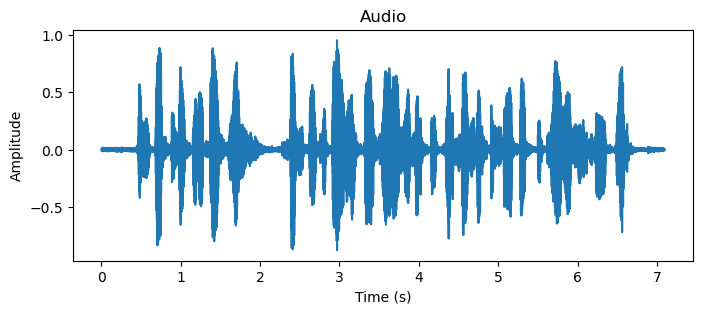

In [20]:
from src.visualization.audio import visualize_audio

visualize_audio(ori_audio)

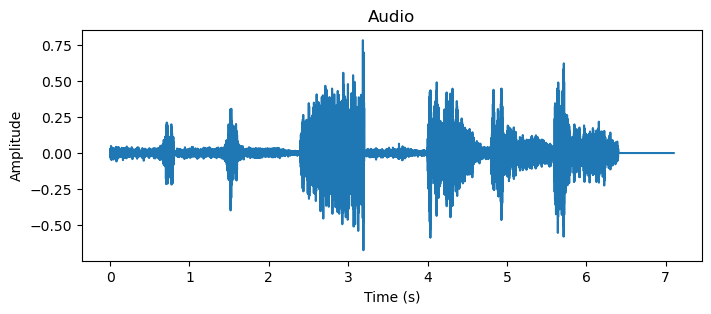

In [21]:
visualize_audio(target_wav)

In [21]:
ori_audio.shape

(131680,)

In [20]:
target_wav.shape

(128000,)